In [1]:
from ctapipe.io import read_table
from ctapipe.instrument import SubarrayDescription
from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates import CameraFrame, EngineeringCameraFrame

from lstchain.io.io import dl1_params_lstcam_key, dl1_images_lstcam_key
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord


%matplotlib inline

In [2]:
SCHOOL_DATASET = '../data'

# Read one example MC gamma DL1 file:
dl1_file = SCHOOL_DATASET+"/DL1ab/dl1_gamma_20deg_180deg_run10___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_off0.4.h5"

# Show where the images (DL1a) are stored in the hdf5 files:
print(dl1_images_lstcam_key)
# read images table:
dl1_images = read_table(dl1_file, dl1_images_lstcam_key)

# Show where the image parameters (DL1b) are stored in the hdf5 files:
print(dl1_params_lstcam_key)
# read parameters table:
dl1_parameters = read_table(dl1_file, dl1_params_lstcam_key)

/dl1/event/telescope/image/LST_LSTCam
/dl1/event/telescope/parameters/LST_LSTCam


## Images table (DL1a):

In [3]:
dl1_images

obs_id,event_id,image [1855],peak_time [1855],image_mask [1855],tel_id,selected_gain_channel [1855]
int32,int64,float32,float32,bool,int64,int8
10,203,3.2416933 .. 1.367029,33.76907 .. 36.390694,False .. False,1,0 .. 0
10,305,2.98566 .. 0.63097006,34.67657 .. 18.551817,False .. False,1,0 .. 0
10,807,1.9743285 .. 1.5280252,17.091505 .. 28.395329,False .. False,1,0 .. 0
10,1305,3.2032883 .. 1.7175437,34.099518 .. 31.712446,False .. False,1,0 .. 0
10,1306,0.5789472 .. 0.6183355,14.148843 .. 19.574656,False .. False,1,0 .. 0
10,1700,1.0326881 .. 4.6393847,1.2975214 .. 36.04619,False .. False,1,0 .. 0
...,...,...,...,...,...,...
10,996709,3.894578 .. 1.4648521,23.405825 .. 13.921883,False .. False,1,0 .. 0
10,997809,2.7424283 .. 1.5125164,33.10476 .. 37.113876,False .. False,1,0 .. 0


The images table stores, for each event and pixel:

- the charge in p.e. ("image")
- the time of the light arrival in ns ("peak time")
- the selected gain channel (i.e. the one used to obtain the charge and time for each pixel; 0 is high gain and 1 is low gain)
- whether the pixel survived cleaning or not ("image_mask"). 

The table entries correspond to the entries in the image parameters table, so you can use the latter to select events in the former and vice versa. An example is shown below.

## Image parameters (DL1b):

In [4]:
dl1_parameters

obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,width,width_uncertainty,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,alt_tel,az_tel,calibration_id,mc_energy,log_mc_energy,mc_alt,mc_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,mc_az_tel,mc_alt_tel,mc_x_max,mc_core_distance,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,trigger_time,event_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y
,,,,m,m,m,rad,deg,deg,deg,deg,rad,,,,,,,,,,,,,,rad,rad,,TeV,,rad,rad,m,m,m,,rad,rad,g / cm2,m,,,m,m,m,,,,,,,,,,
int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,float64,float64,float64,int64,float32,float32,int64,float64,float64,float64,float64,float64,float64,float64,int64,float32,float32,float64,float64,float64,int64,float32,float32,float32,int64,float64,int64,float32,float32,float32,float32,float32,float32,float32
10,203,962.8705058097839,2.9835678838080453,0.3766974602643858,0.26971417149196647,0.4632998066837891,0.6213815773923851,0.24815977452129712,0.004030397377545174,0.0619686899171285,0.0017828682792850746,1.0450031096906351,0.3056190562506361,2.0159104053672605,-0.21659176719269446,13.64311892205307,0.0,0.0,0.0,0.0,33,0.22510800919030083,0.32881654974163843,0.1100011336830042,1,1.2147492,3.1415927,-1,0.15828366577625275,-0.8005639002308581,1.2217304706573486,3.1415927410125732,8.300270080566406,35.978363037109375,32226.966796875,0,3.1415927,1.2147492,211.7142791748047,118.44808958008554,0.24971287162339975,1,-70.93,-52.07,43.0,32,1606641878.637238,32,-0.18122113,-0.26971418,0.32494128,0.9791789,-1.0,0.19547632,2.4369417e-12
10,305,149.3123745918274,2.1740958023281083,0.35931261696823574,0.3472054902547814,0.4996570915894472,0.7682635115076883,0.08101828811444416,0.003343657773299832,0.04419573569473079,0.001970080716869115,0.9889772048497784,0.19293724555377859,2.017261789838703,10.935135179831597,12.197618646094819,0.0,0.0,0.0,0.0,7,0.6043930052285348,0.2320471214029143,0.2814084832200045,1,1.2147492,3.1415927,-1,0.019269723445177078,-1.715124518198486,1.2217304706573486,3.1415927410125732,-3.2260520458221436,65.57146453857422,13098.6416015625,0,3.1415927,1.2147492,300.0,135.73260005202582,0.5455032033298597,1,-70.93,-52.07,43.0,32,1606641881.287831,32,-0.16383629,-0.3472055,0.38391924,1.1299039,-1.0,0.19547632,2.4369417e-12
10,807,72.09015560150146,1.8578759629184929,0.2878696468924734,0.1189431495081443,0.3114745678493095,0.39182002688315043,0.056328301320089445,0.0036427412108808537,0.04793818901165001,0.005123616118763505,1.3574230113168178,0.06372908224720068,2.205976942850693,0.5132910904181358,11.710806029052996,0.0,0.0,0.0,0.0,5,0.8697589415769844,0.5453376042787169,0.5453376042787169,1,1.2147492,3.1415927,-1,0.02786845527589321,-1.5548871031829294,1.2217304706573486,3.1415927410125732,5.178720474243164,37.719139099121094,25513.671875,0,3.1415927,1.2147492,173.3333282470703,117.70567880963914,0.8510497900378348,1,-70.93,-52.07,43.0,32,1606641883.221573,32,-0.092393324,-0.11894315,0.15061209,0.91037166,-1.0,0.19547632,2.4369417e-12
10,1305,96.84340810775757,1.9860700647055518,0.1317722835591362,-0.7763373434297733,0.7874411759096595,-1.402662905469697,0.11424273081764584,0.0053127722732090165,0.059980675645949375,0.0044843771686004725,1.4454657239802742,0.3264290962287411,1.837749461391416,-21.283126954978272,12.778992947743582,0.0,0.0,0.0,0.0,8,0.4982243143167628,0.4982243143167628,0.1871197374108231,1,1.2147492,3.1415927,-1,0.4249720871448517,-0.3716395941780785,1.2217304706573486,3.1415927410125732,-89.23172760009766,-393.1084899902344,29089.869140625,0,3.1415927,1.2147492,211.81817626953125,341.5292155657408,0.5250283778815694,1,-70.93,-52.07,43.0,32,1606641886.153733,32,0.06370404,0.

Image adapted from https://github.com/cta-observatory/ctapipe/issues/1078#issuecomment-495663160
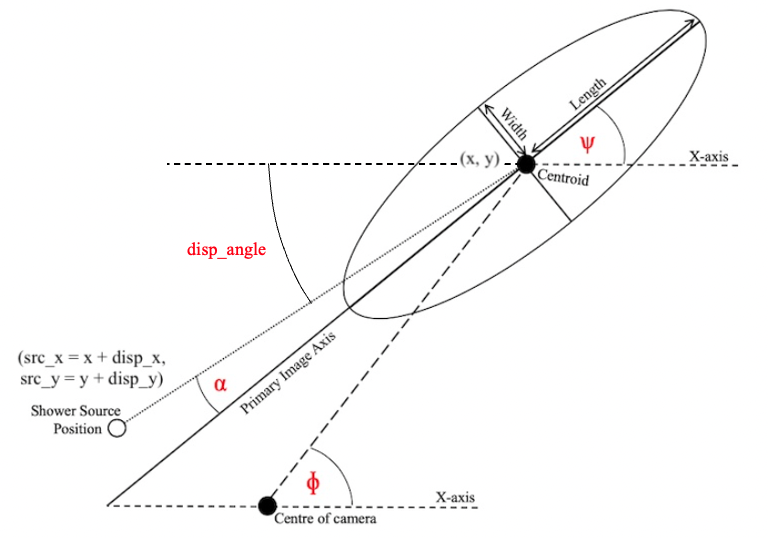

Description of parameters in\
https://github.com/cta-observatory/cta-lstchain/blob/master/lstchain/io/lstcontainers.py

All parameters are calculated using the charge, time and coordinates of the pixels surviving the cleaning.

The main parameters are basically moments of the charge distribution. Order 1: image centroid or "center of gravity" (x, y). Order 2 (along the major and minor image axes): Length and Width. Order 3 and 4 (along the major image axis): skewness and kurtosis. Intensity is the sum of the pixels' charges. From a linear fit to the peak_time vs. the distance to the centroid along the major axis we obtain the time_gradient


Notes: 
- these DL1 files are provisional and LST-specific. Eventually we will use the agreed DL1 model already implemented in ctapipe:\
    https://cta-observatory.github.io/ctapipe/data_models/dl1.html#dl1-data-model


- the table contains nans for parameters which could not be calculated for whatever reason (e.g. no pixels survived cleaning)


- parameters like coordinates and angles are in the standard camera frame, ctapipe.coordinates.CameraFrame. Below we will show how to transform them to the more commonly used EngineeringCameraFrame (which is how we would see the camera with the telescope in parking position)


- there are some parameters which do not change event-wise, yet they are written in the events table for convenience (tel_id, tel_pos_x, tel_pos_y, tel_pos_z)


- there is also redundant information: in MC files mc_alt_tel, mc_az_tel are identical to alt_tel, az_tel. Energy (in MC) and intensity appear also in logarithmic form.


- mc_type (primary type, in eventio convention): 0 (gamma), 1(e-), 2(mu-), 100*A+Z for nucleons and nuclei, negative for antimatter


- Some parameters don't have their units in the table (if not mentioned below, they are adimensional):
 - intensity: photoelectrons  (log_intensity is just log10 of that)
 - intercept: ns (it is the fitted time value at the image charge COG)
 - time_gradient: ns / deg (slope of the linear time fit along the major image axis)
 - trigger_time is a unix timestamp in seconds - for simulations it is just the event sim_telarray simulation time, so it has no physical meaning.

 Only for MC:
 - src_x src_y: meters. True event direction on the camera. 
 - disp_dx, disp_dy, disp_norm: meters. Note: these are __*not*__ reconstructed values, but true ones (calculated with the true event direction) for the purpose of training the direction reconstruction. With the x, y in the table being the coordinates of the image center of gravity, disp_dx = src_x - x, and disp_dy = src_y - y 
 - disp_angle: radians (-pi/2 to pi/2). It is equal to tan(disp_dy/disp_dx)



### We will now show how to select and plot an event from the DL1 file:


In [5]:
subarray_info = SubarrayDescription.from_hdf(dl1_file) # Read instrument description, needed for camera display

camgeom = subarray_info.tel[1].camera.geometry
camgeom = camgeom.transform_to(EngineeringCameraFrame())

nevents: 7
________________________________________________________________________________________________________

Event id 246807:
x: 0.211 m
y: -0.369 m
psi: -34.334 deg
width: 0.122 deg
length: 0.303 deg
mc_core_distance: 51.2 m


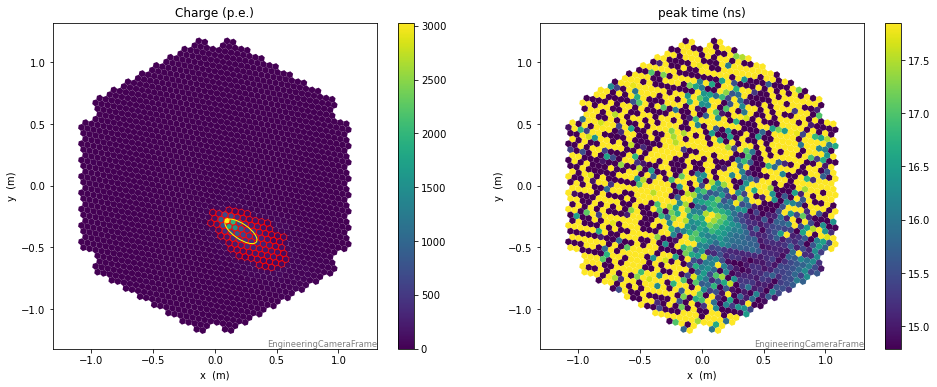

________________________________________________________________________________________________________

Event id 335007:
x: -0.358 m
y: 0.207 m
psi: -49.406 deg
width: 0.144 deg
length: 0.453 deg
mc_core_distance: 53.1 m


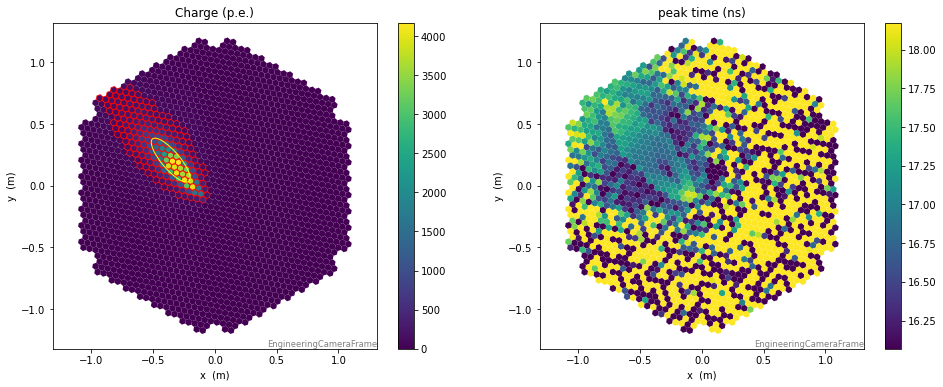

________________________________________________________________________________________________________

Event id 365702:
x: -0.025 m
y: 0.444 m
psi: -87.753 deg
width: 0.105 deg
length: 0.472 deg
mc_core_distance: 134.2 m


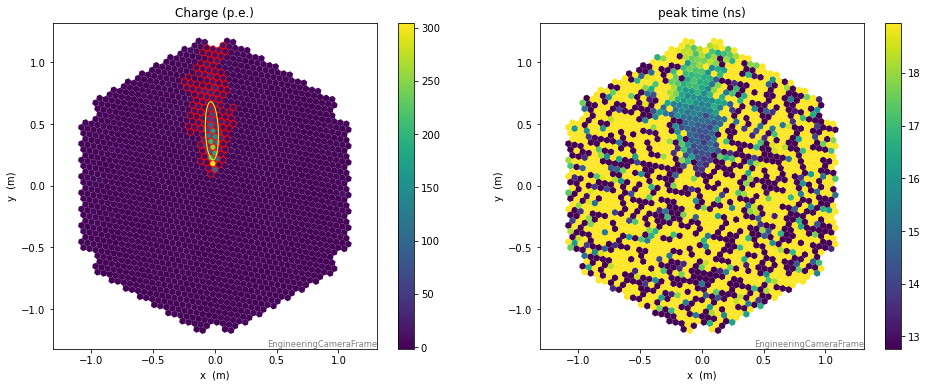

________________________________________________________________________________________________________

Event id 436606:
x: -0.215 m
y: -0.322 m
psi: -160.640 deg
width: 0.143 deg
length: 0.262 deg
mc_core_distance: 68.8 m


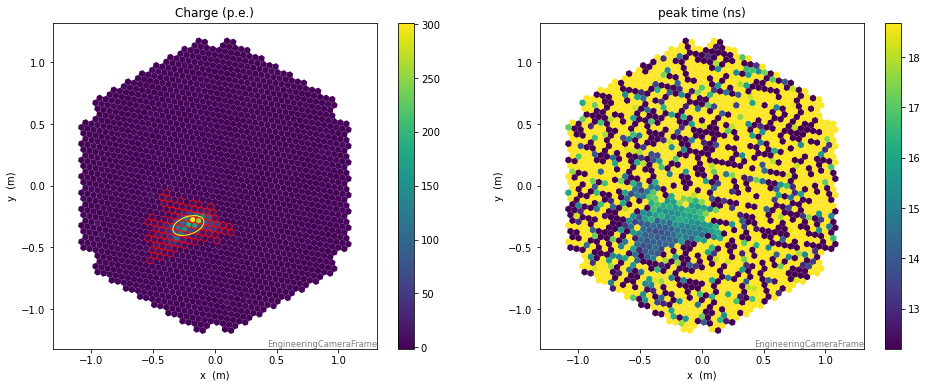

________________________________________________________________________________________________________

Event id 620702:
x: -0.052 m
y: 0.367 m
psi: -80.762 deg
width: 0.111 deg
length: 0.431 deg
mc_core_distance: 167.9 m


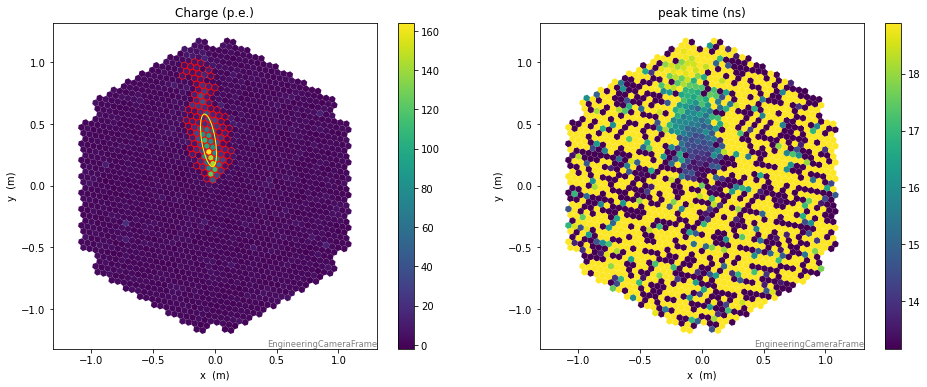

________________________________________________________________________________________________________

Event id 694607:
x: 0.234 m
y: -0.067 m
psi: -152.409 deg
width: 0.158 deg
length: 0.260 deg
mc_core_distance: 32.8 m


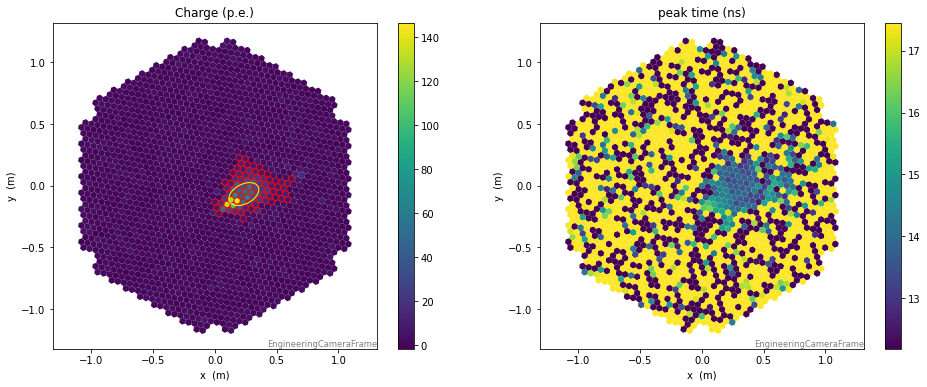

________________________________________________________________________________________________________

Event id 710605:
x: -0.067 m
y: 0.444 m
psi: -83.457 deg
width: 0.077 deg
length: 0.563 deg
mc_core_distance: 128.8 m


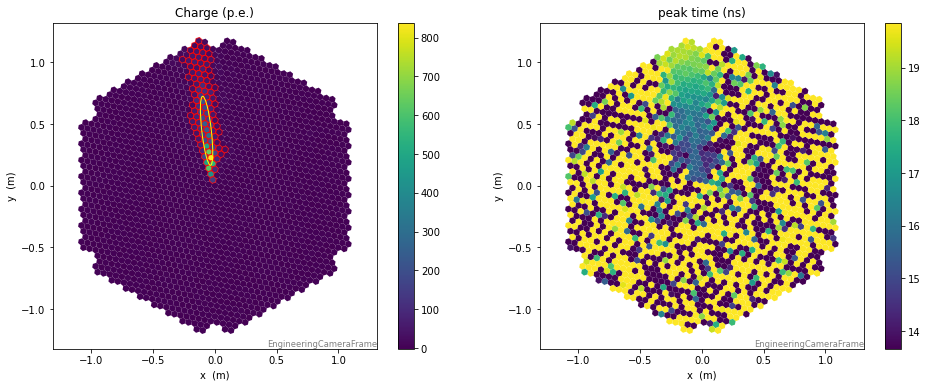

In [6]:
# Locate table entries for which n_pixels (after cleaning) is larger than 80 p.e., 
# and with c.o.g. within 0.5 m of the camera center ('good-looking' events):

mask = ((dl1_parameters['n_pixels']>80) & 
        (dl1_parameters['r']<0.5*u.m)
       )
nevents = len(np.where(mask)[0]) # number of events fulfilling the above cuts
print('nevents:', nevents)

indices = np.where(mask)[0] # indices of events fulfilling the condition above

# JUST LIMIT TO 10 THE MAXIMUM NUMBER OF DISPLAYED EVENTS TO AVOID TOO MUCH PLOTTING:
if nevents > 10:
    indices = indices[:9]

for index in indices:

    fig = plt.figure(figsize=(16,6))
    fig.add_subplot(1, 2, 1)
    
    # Display charge in p.e. in each pixel:
    camdisplay = CameraDisplay(camgeom, dl1_images['image'][index], title='Charge (p.e.)')

    # Get and highlight pixels which survived cleaning:
    cleanmask = dl1_images['image_mask'][index]
    camdisplay.highlight_pixels(cleanmask, color='red')


    # Note: 
    # Transform image c.o.g. coordinates to the engineering camera frame:
    cog = SkyCoord(dl1_parameters['x'], dl1_parameters['y'], frame=CameraFrame)
    cog_engineering = cog.transform_to(EngineeringCameraFrame())
    # Transform image main axis orientation psi to engineering camera frame:
    psi = dl1_parameters['psi']
    main_axis_versor = SkyCoord(np.cos(psi).value * u.m, np.sin(psi).value * u.m, frame=CameraFrame())
    main_axis_versor_engineering = main_axis_versor.transform_to(EngineeringCameraFrame())
    psi_engineering = np.arctan2(main_axis_versor_engineering.y, main_axis_versor_engineering.x)
    # (not sure if there is an easier way...)

    width = dl1_parameters['width'].quantity[index]
    length = dl1_parameters['length'].quantity[index]
    mc_core_distance = dl1_parameters['mc_core_distance'].quantity[index]
    
    # Show Hillas ellipse overlaid:
    camdisplay.add_ellipse((cog_engineering.x[index].value, 
                            cog_engineering.y[index].value), 
                            length.value, width.value,
                            psi_engineering[index].value, color='yellow')


    # Print parameter values:
    print('________________________________________________________________________________________________________')
    print()
    print(f"Event id {dl1_parameters['event_id'][index]}:")
    print(f'x: {cog_engineering.x[index]:.3f}')
    print(f'y: {cog_engineering.y[index]:.3f}')
    print(f'psi: {np.rad2deg(psi_engineering[index]):.3f}')
    print(f"width: {width:.3f}")
    print(f"length: {length:.3f}")
    print(f"mc_core_distance: {mc_core_distance:.1f}")

    camdisplay.add_colorbar()


    fig.add_subplot(1, 2, 2)
    # Display peak time (ns) of signal in each pixel
    # Set z range according to pixels which survived cleaning

    tmin = np.min(dl1_images['peak_time'][index][cleanmask])
    tmax = np.max(dl1_images['peak_time'][index][cleanmask])

    camdisplay = CameraDisplay(camgeom, dl1_images['peak_time'][index], 
                               title='peak time (ns)')
    camdisplay.set_limits_minmax(tmin, tmax)
    camdisplay.add_colorbar()

    plt.show()

## The lstchain_dl1ab.py script
With the DL1 files which contain DL1a (pixel-wise) information, we can re-do the cleaning and the image parametrization with different settings, and obtain a new set of parameters. We do this with the lstchain_dl1ab.py script. Explanations on how to do this, and more exercises using DL1 data are available in separate notebooks:

https://github.com/cta-observatory/2022_01_lstchain_school/blob/main/DL1a_to_DL1b/explore_dl1_MC.ipynb

https://github.com/cta-observatory/2022_01_lstchain_school/blob/main/DL1a_to_DL1b/explore_dl1_realdata.ipynb
